In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Get current working directory (where notebook is running)
current_dir = os.getcwd()
# Go up one level, then into utils
utils_path = os.path.abspath(os.path.join(current_dir, '..', 'utils'))
# Add to sys.path
sys.path.append(utils_path)

from trend_regime_utils import load_trend_data, process_trend_data, create_advanced_feat, mayority_vote_cluster_smooth
from bull_trend_regime_utils import load_bull_trend_data, create_advanced_bull_feat, merge_clean_final_clusters

import pandas as pd
import numpy as np
from datetime import datetime
from zoneinfo import ZoneInfo
import joblib

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout, BatchNormalization, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_recall_curve, average_precision_score
import re 
import random

# for determinstic purposes
SEED = 22
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
tf.keras.backend.set_floatx('float64')
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

# For API Keys
from dotenv import load_dotenv
# Alpaca API keys
API_KEY = None
SECRET_KEY = None

load_dotenv(override=True)

if API_KEY is None:
    API_KEY = os.environ.get('ALP_API_KEY')

if SECRET_KEY is None:
    SECRET_KEY = os.environ.get('ALP_SEC_KEY')

Prepare the data for the first regime detection model

In [2]:
EARLIEST_DATE = datetime(2016, 1, 16, tzinfo=ZoneInfo('America/New_York'))
LAST_DATE = datetime(2025, 7, 20, tzinfo=ZoneInfo('America/New_York'))

df_trend_raw = load_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE)

df_trend_processed = process_trend_data(df_trend_raw)

df_trend_feat = create_advanced_feat(df_trend_processed)

c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:96: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:96: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:96: FutureWar

Load all needed to execute the model and create predictions

In [3]:
# Get the project root (one level up from current working directory)
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
MODEL_DIR = os.path.join(PROJECT_ROOT, 'models')

os.makedirs(MODEL_DIR, exist_ok=True)

# Load models
scaler = joblib.load(os.path.join(MODEL_DIR, "trend_scaler.pkl"))
umap_model = joblib.load(os.path.join(MODEL_DIR, "trend_umap_model.pkl"))
gmm_model = joblib.load(os.path.join(MODEL_DIR, "trend_gmm_model.pkl"))

# scale data
trend_scaled = scaler.transform(df_trend_feat)

# Apply UMAP transformation
trend_umap = umap_model.transform(trend_scaled)

# Predict clusters
trend_gmm_labels = gmm_model.predict(trend_umap)

# from sklearn.metrics import silhouette_score
# print(silhouette_score(trend_umap, trend_gmm_labels))

df_with_clusters = pd.DataFrame(trend_gmm_labels, columns=["cluster"], index=df_trend_feat.index)

df_cluster_smooth = mayority_vote_cluster_smooth(df_with_clusters)

Secondary regime detection (bull split)

In [4]:
df_bull_raw = load_bull_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE)

bull_features_df = create_advanced_bull_feat(df_bull_raw)

In [5]:
# keep only bull days 
bull_days = df_cluster_smooth[df_cluster_smooth==1]

# Keep only rows in bull_features_df where the index exists in bull_days
only_bull_features_df = bull_features_df[bull_features_df.index.isin(bull_days.index)]

In [6]:
# Load models
bull_scaler = joblib.load(os.path.join(MODEL_DIR, "bull_trend_scaler.pkl"))
bull_umap_model = joblib.load(os.path.join(MODEL_DIR, "bull_trend_umap_model.pkl"))
spectral_model = joblib.load(os.path.join(MODEL_DIR, "bull_trend_spectral_model.pkl"))

# scale data
bull_trend_scaled = bull_scaler.transform(only_bull_features_df)

# Apply UMAP transformation
bull_trend_umap = bull_umap_model.transform(bull_trend_scaled)

# Predict clusters, SpectralClustering doesn’t have a .predict() method for unseen data.
# Every time you call fit_predict(), it re-computes clusters from scratch, so for new data, you need to re-run it on all data (old + new)
bull_trend_spectral_labels = spectral_model.fit_predict(bull_trend_umap)

# from sklearn.metrics import silhouette_score
# print(silhouette_score(bull_trend_umap, bull_trend_spectral_labels))

c:\Users\sergi\Documents\TFG\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [7]:
# compute final clusters
df_final_clusters = merge_clean_final_clusters(bull_trend_spectral_labels, only_bull_features_df, df_with_clusters)

df_final_clusters.value_counts(normalize=True, dropna=False)

final_cluster
1                0.252178
0                0.238881
2                0.188904
3                0.176066
4                0.143971
Name: proportion, dtype: float64

Start of strategy returns prediction, data processing

In [8]:
tickers_to_trade = [
    "SPY",  # S&P 500 ETF
    "EFA",  # MSCI EAFE (Developed Markets ex-US) ETF
    # "EEM",  # MSCI Emerging Markets ETF
    # "TLT",  # 20+ Year Treasury Bond ETF
    # "GLD",  # Gold ETF
    "USO",  # Crude Oil ETF
    "QQQ",  # Nasdaq 100 ETF
    # "IWM"   # Russell 2000 ETF
]

df_trade_raw = load_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE, all_tickers=tickers_to_trade)

print("NAs: ", df_trade_raw.pivot(columns="symbol").isna().sum().sum())

NAs:  0


##### Trading Strategies

We have 3 main strategies, each with 3 variations:

1. SMA Crossover (Simple Moving Average)

| Version | Short SMA | Long SMA |
|---------|-----------|----------|
| S1-1    | 5 days    | 10 days  |
| S1-2    | 10 days   | 20 days  |
| S1-3    | 14 days   | 28 days  |

2. RSI (Relative Strength Index)

| Version | Period |
|---------|--------|
| S2-1    | 7 days |
| S2-2    | 14 days|
| S2-3    | 21 days|

3. Bollinger Bands

| Version | SMA Period | Std Dev Multiplier |
|---------|------------|------------------|
| S3-1    | 10 days    | 1                |
| S3-2    | 20 days    | 1                |
| S3-3    | 40 days    | 1.5              |


In [9]:
def add_sma_crossover(df, short_window, long_window, signal_name):
    """Buy when short SMA crosses above long SMA, sell when crosses below."""
    """Trend-following / Momentum"""
    df = df.copy()
    df['SMA_short'] = df['close'].rolling(short_window).mean()
    df['SMA_long'] = df['close'].rolling(long_window).mean()
    df[signal_name] = np.where(df['SMA_short'] > df['SMA_long'], 1, -1)
    return df.drop(columns=['SMA_short', 'SMA_long'])

def add_rsi(df, period, signal_name):
    """Buy when RSI < 30 (oversold), sell when RSI > 70 (overbought)."""
    """Mean reversion"""
    df = df.copy()
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi
    df[signal_name] = np.where(df['RSI'] < 30, 1, np.where(df['RSI'] > 70, -1, 0)) # 65 35 for large periods maybe
    return df.drop(columns=['RSI'])


def add_bollinger_bands(df, window, num_std, signal_name):
    """Buy when price closes below lower band, sell when above upper band."""
    """Volatility breakout & Reversion"""
    df = df.copy()
    sma = df['close'].rolling(window).mean()
    rolling_std = df['close'].rolling(window).std()
    upper_band = sma + num_std * rolling_std
    lower_band = sma - num_std * rolling_std
    df[signal_name] = np.where(df['close'] < lower_band, 1, np.where(df['close'] > upper_band, -1, 0))
    return df

# ---- Apply all strategies ----
def add_all_strategies(df):
    df = add_sma_crossover(df, short_window=5, long_window=10, signal_name="S1_1_signal")
    df = add_sma_crossover(df, short_window=10, long_window=20, signal_name="S1_2_signal")
    df = add_sma_crossover(df, short_window=14, long_window=28, signal_name="S1_3_signal")
    df = add_rsi(df, period=7, signal_name="S2_1_signal")
    df = add_rsi(df, period=14, signal_name="S2_2_signal")
    df = add_rsi(df, period=21, signal_name="S2_3_signal")
    df = add_bollinger_bands(df, window=10, num_std=1, signal_name="S3_1_signal")
    df = add_bollinger_bands(df, window=20, num_std=1, signal_name="S3_2_signal")
    df = add_bollinger_bands(df, window=40, num_std=1.5, signal_name="S3_3_signal")
    return df

df_strats = add_all_strategies(df_trade_raw)

# Signals are numeric:
# 1 = long bias,
# -1 = short bias,
# 0 = neutral (for RSI & Bollinger).

# No lookahead bias in signal generation: All rolling and EMA operations use only past data.

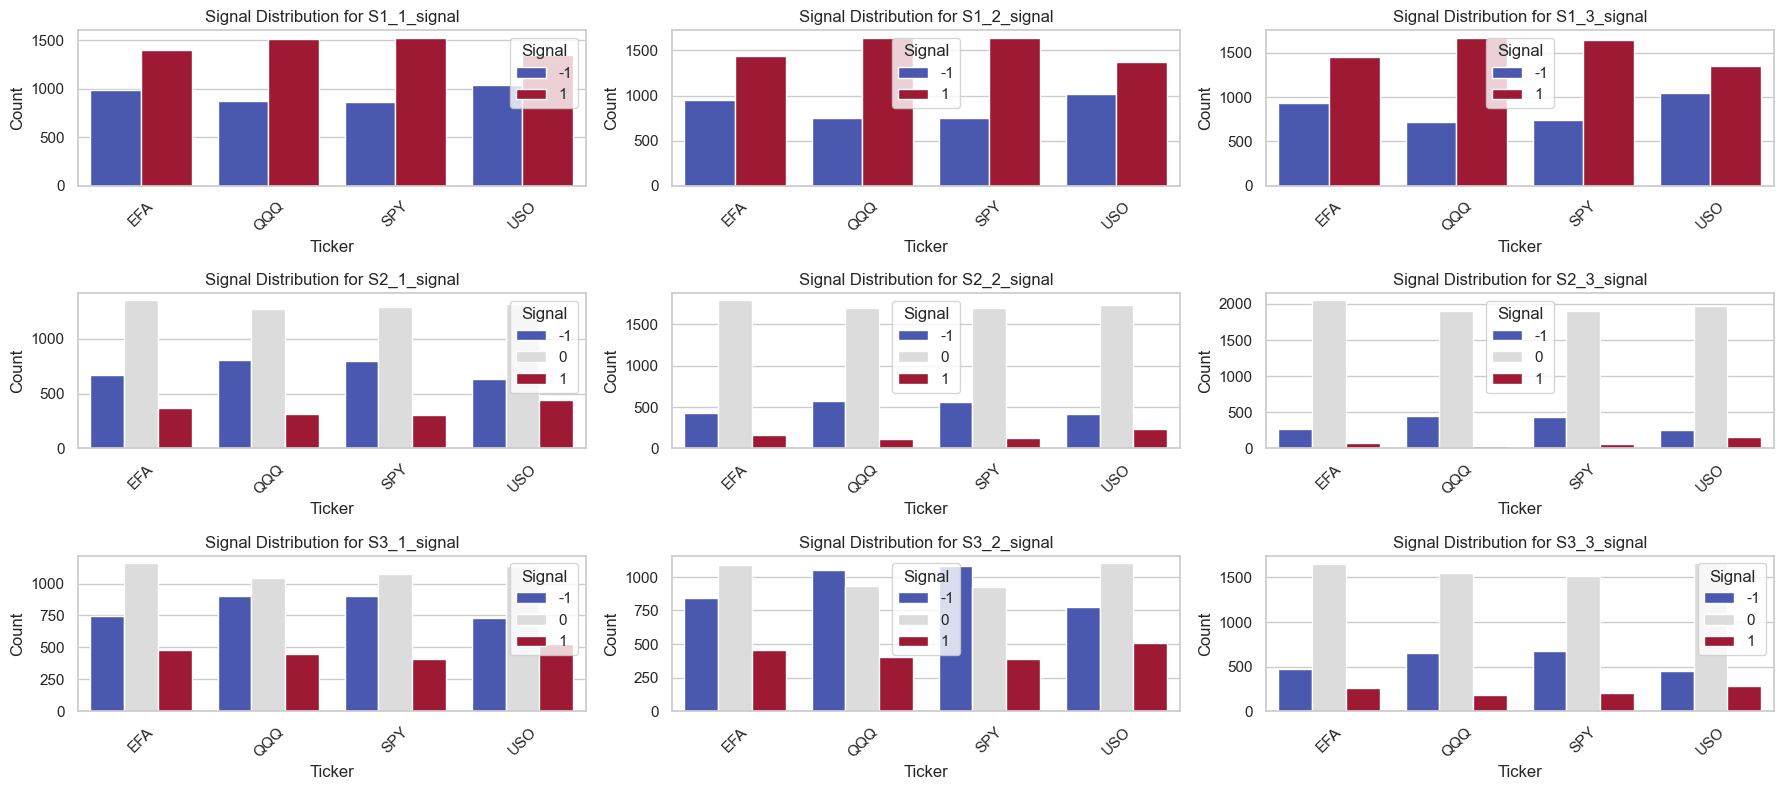

In [10]:
def plot_signal_distribution(df, signal_cols, symbol_col='symbol'):
    """
    Plots barplots showing distribution of signal values (1, 0, -1)
    per ticker and per strategy in a 3x2 subplot layout.
    """
    sns.set(style="whitegrid")
    
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 10))
    axes = axes.flatten()  #flatten to easily iterate
    
    for i, strat in enumerate(signal_cols):
        ax = axes[i]
        
        #count frequency of each signal per ticker
        counts = (
            df.groupby(symbol_col)[strat]
            .value_counts()
            .unstack(fill_value=0)
            .reset_index()
            .melt(id_vars=symbol_col, var_name='Signal', value_name='Count')
        )
        
        # Plot on the corresponding subplot
        sns.barplot(data=counts, x=symbol_col, y='Count', hue='Signal', palette='coolwarm', ax=ax)
        
        ax.set_title(f"Signal Distribution for {strat}", fontsize=12)
        ax.set_xlabel("Ticker")
        ax.set_ylabel("Count")
        ax.legend(title="Signal")
        ax.tick_params(axis='x', rotation=45)

    for j in range(len(signal_cols), 12):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

strategies = ["S1_1_signal", "S1_2_signal", "S1_3_signal", "S2_1_signal", "S2_2_signal", "S2_3_signal", "S3_1_signal", "S3_2_signal", "S3_3_signal"]

plot_signal_distribution(df_strats, strategies)

In [11]:
# number of days that the strategy will have to compute returns
HORIZON = 10

In [12]:
# Computation of returns
def compute_forward_returns(df, horizon=HORIZON):
    """
    For each symbol and timestamp, compute forward return over `horizon` days.
    Forward return = (close at t+horizon / close at t) - 1
    """
    df = df.copy()
    df['forward_return'] = df.groupby('symbol')['close'].shift(-horizon) / df['close'] - 1
    return df

def generate_strategy_returns(df, horizon=HORIZON):
    """
    For each strategy S1..S3, compute forward return assuming you go LONG when signal=1,
    SHORT when signal=-1, and 0 when neutral (signal=0).
    
    The strat_return per row per strategy is:
      forward_return * signal at current time
    
    Returns a DataFrame in long format:
      ['symbol', 'timestamp', 'strategy', 'signal', 'forward_return', 'strat_return']
    """
    df = df.copy()
    df = compute_forward_returns(df, horizon=horizon)
    
    strategy_cols = ["S1_1_signal", "S1_2_signal", "S1_3_signal", "S2_1_signal", "S2_2_signal", "S2_3_signal", "S3_1_signal", "S3_2_signal", "S3_3_signal"]
    records = []
    
    for strat in strategy_cols:
        temp = df[['symbol', 'close', strat, 'forward_return']].copy()
        temp = temp.rename(columns={strat: 'signal'})
        temp['strategy'] = strat
        
        # strat_return is forward return weighted by position signal
        # Long = profit if price rises, Short = profit if price falls
        temp['strat_return'] = temp['forward_return'] * temp['signal']
        
        # Remove neutral signals to reduce noise so the model can focus on performance conditional on entering a trade 
        temp = temp[temp['signal'] != 0]
        
        records.append(temp[['symbol', 'strategy', 'signal', 'forward_return', 'strat_return']])
    
    df_strat_returns = pd.concat(records).reset_index()
    return df_strat_returns.set_index('timestamp')


df_return_strats = generate_strategy_returns(df_strats, horizon=HORIZON)

In [13]:
# shift clusters one day back since they are computed at the end of the day, so that info is not available at the start of the day
shifted_regimes = df_final_clusters[["final_cluster"]].shift(1).dropna().astype(int) #  drop frist day since is nan

# join with clusters (first months have no cluster so have to drop them)
df_joined = df_return_strats.join(shifted_regimes, how='inner')
df_joined.rename(columns={"final_cluster": "prev_regime"}, inplace=True)

df_joined.drop(columns="forward_return", inplace=True)
# drop last days without available returns
df_joined.dropna(subset=['strat_return'], inplace=True)

df_joined

,symbol,strategy,signal,strat_return,prev_regime
timestamp,,,,,
2016-11-14 05:00:00+00:00,EFA,S1_1_signal,1,0.001832,3
2016-11-15 05:00:00+00:00,EFA,S1_1_signal,-1,0.003877,3
2016-11-16 05:00:00+00:00,EFA,S1_1_signal,-1,-0.003458,3
2016-11-17 05:00:00+00:00,EFA,S1_1_signal,-1,0.002059,3
2016-11-18 05:00:00+00:00,EFA,S1_1_signal,-1,-0.019426,3
...,...,...,...,...,...
2025-06-13 04:00:00+00:00,USO,S3_3_signal,-1,0.088631,1
2025-06-16 04:00:00+00:00,USO,S3_3_signal,-1,0.059295,1
2025-06-17 04:00:00+00:00,USO,S3_3_signal,-1,0.081531,1


C:\Users\sergi\AppData\Local\Temp\ipykernel_64376\2106991831.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


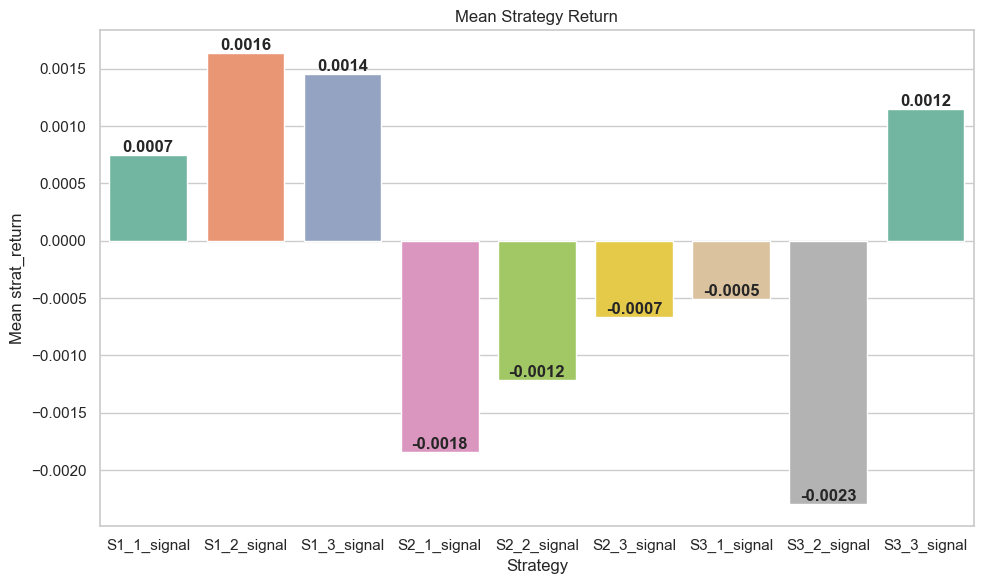

In [14]:
def plot_mean_return_per_strategy(df):
    """
    Plot mean strat_return grouped only by strategy.
    """
    grouped = df.groupby('strategy')['strat_return'].mean().reset_index()

    sns.set(style='whitegrid')

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=grouped,
        x='strategy',
        y='strat_return',
        palette='Set2'
    )

    plt.title('Mean Strategy Return')
    plt.xlabel('Strategy')
    plt.ylabel('Mean strat_return')

    # Add value annotations on top of bars
    for i, row in grouped.iterrows():
        plt.text(i, row['strat_return'], f'{row["strat_return"]:.4f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_mean_return_per_strategy(df_joined)

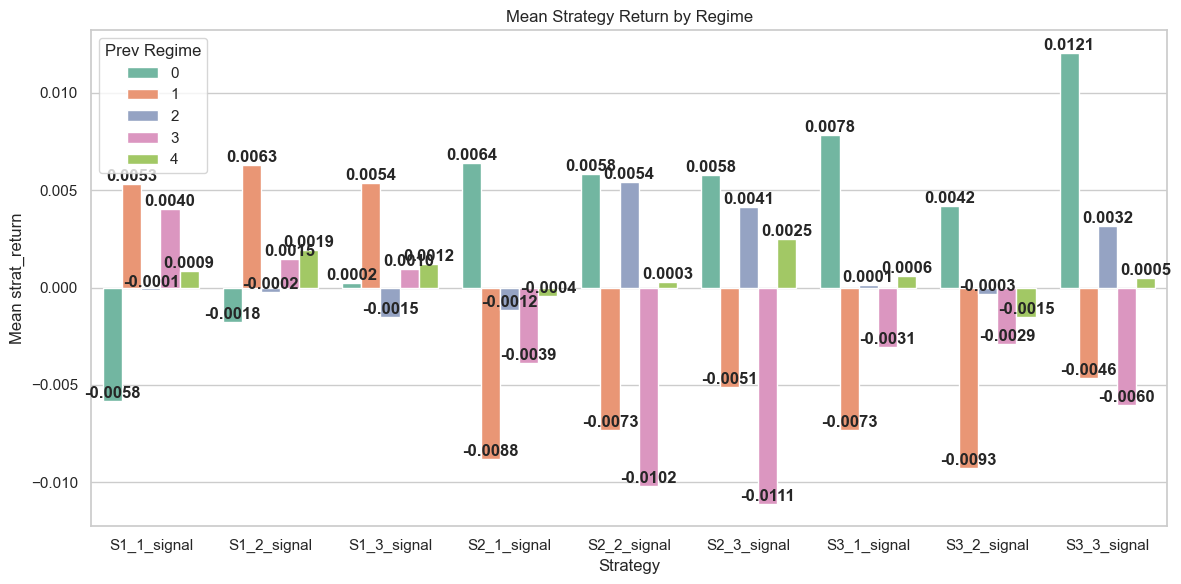

In [15]:
def plot_mean_return_by_strategy_and_regime(df):
    """
    Plot mean strat_return grouped by strategy and prev_regime.
    """
    grouped = df.groupby(['strategy', 'prev_regime'])['strat_return'].mean().reset_index()

    sns.set(style='whitegrid')

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=grouped,
        x='strategy',
        y='strat_return',
        hue='prev_regime',
        palette='Set2'
    )

    plt.title('Mean Strategy Return by Regime')
    plt.xlabel('Strategy')
    plt.ylabel('Mean strat_return')
    plt.legend(title='Prev Regime')

    # Add value annotations on top of bars
    for i, bar in enumerate(plt.gca().patches):
        height = bar.get_height()
        if height: 
            plt.gca().text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{height:.4f}',
                ha='center',
                va='bottom',
                fontweight='bold'
            )

    plt.tight_layout()
    plt.show()

plot_mean_return_by_strategy_and_regime(df_joined)

C:\Users\sergi\AppData\Local\Temp\ipykernel_64376\3310086822.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\sergi\AppData\Local\Temp\ipykernel_64376\3310086822.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\sergi\AppData\Local\Temp\ipykernel_64376\3310086822.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\sergi\AppData\Local\Temp\ipykernel_64376\3310086822.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xti

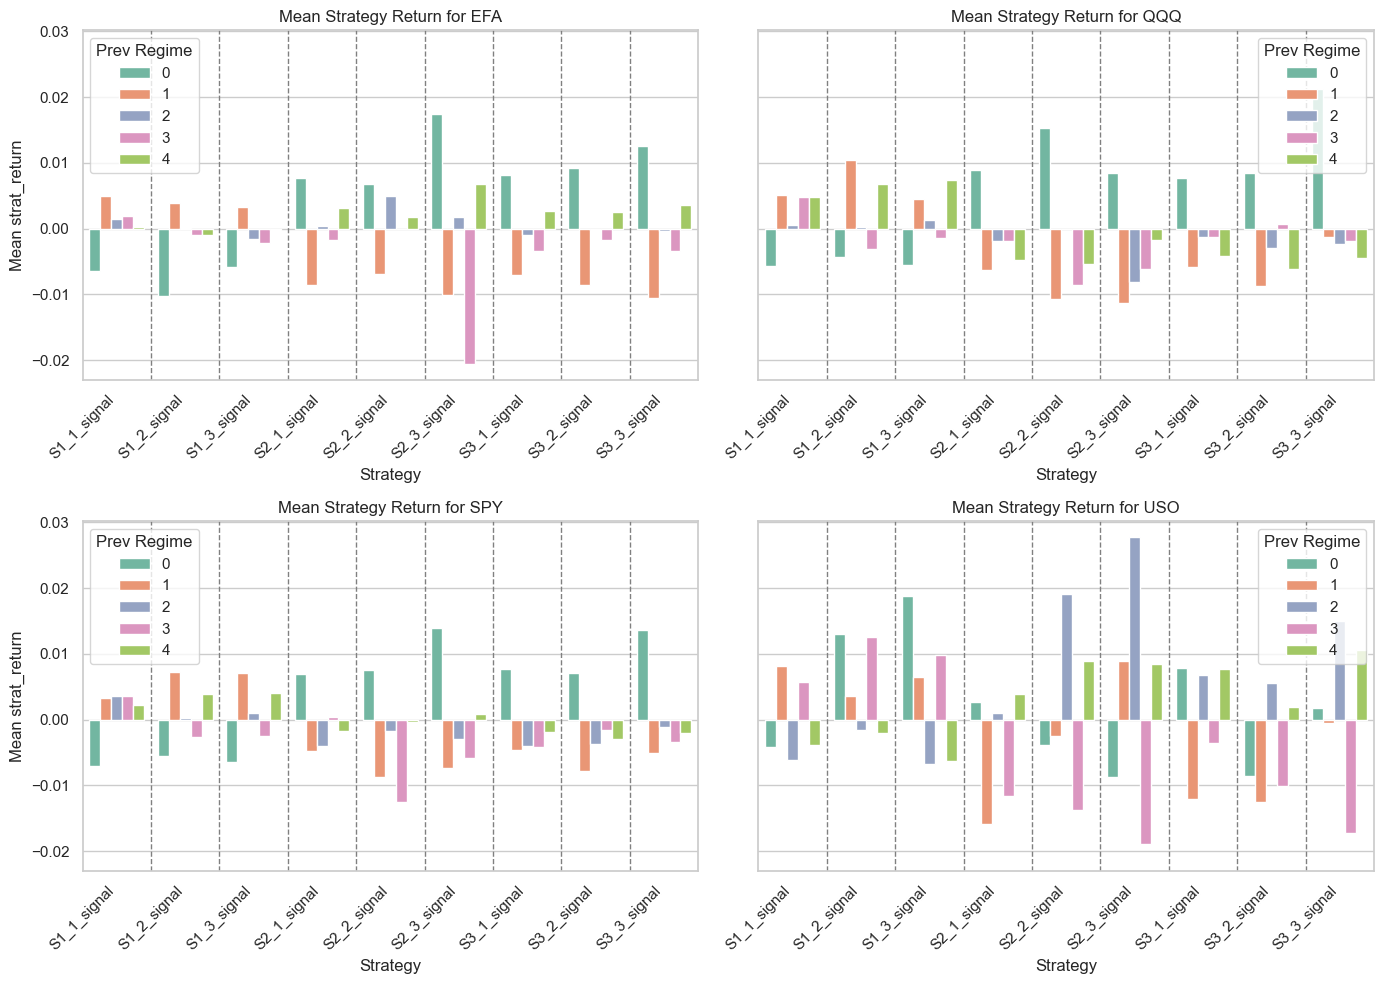

In [16]:
def plot_mean_strat_return(df):
    """
    Plot mean strat_return grouped by symbol, strategy, and prev_regime.
    """
    grouped = df.groupby(['symbol', 'strategy', 'prev_regime'])['strat_return'].mean().reset_index()

    sns.set(style='whitegrid')

    symbols = grouped['symbol'].unique()
    n_symbols = len(symbols)

    cols = 2
    rows = (n_symbols + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows), sharey=True)
    axes = axes.flatten()

    for i, sym in enumerate(symbols):
        ax = axes[i]
        data = grouped[grouped['symbol'] == sym]

        sns.barplot(
            data=data,
            x='strategy',
            y='strat_return',
            hue='prev_regime',
            ax=ax,
            palette='Set2'
        )

        ax.set_title(f'Mean Strategy Return for {sym}')
        ax.set_xlabel('Strategy')
        ax.set_ylabel('Mean strat_return')
        ax.legend(title='Prev Regime')

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

        n_strategies = data['strategy'].nunique()
        for pos in range(0, n_strategies - 1):
            ax.axvline(pos + 0.5, color='gray', linestyle='--', linewidth=1)

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_mean_strat_return(df_joined)

In [17]:
# add some additional features/technical indicators for the neural network
def add_features(df):
    df = df.copy()

    # 1. Returns
    df['return_1d'] = df['close'].pct_change(1)
    df['return_3d'] = df['close'].pct_change(3)
    df['return_5d'] = df['close'].pct_change(5)

    # # 2. Volatility (rolling std of returns)
    df['log_return_1d'] = np.log(df['close'] / df['close'].shift(1))
    df['vol_5d'] = df['log_return_1d'].rolling(window=5).std()
    df['vol_10d'] = df['log_return_1d'].rolling(window=10).std()
    df.drop(columns="log_return_1d",  inplace=True)

    # 3. Momentum (price relative to N-day ago)
    df['mom_5d'] = df['close'] / df['close'].shift(5) - 1
    df['mom_10d'] = df['close'] / df['close'].shift(10) - 1
    df['mom_20d'] = df['close'] / df['close'].shift(20) - 1

    # 4. Moving averages
    df['sma_5d'] = df['close'].rolling(window=5).mean()
    df['sma_10d'] = df['close'].rolling(window=10).mean()
    df['sma_20d'] = df['close'].rolling(window=20).mean()

    # 5. Price relative to moving averages
    df['price_div_sma5'] = df['close'] / df['close'].rolling(window=5).mean() - 1
    df['price_div_sma10'] = df['close'] / df['close'].rolling(window=10).mean() - 1
    df['price_div_sma20'] = df['close'] / df['close'].rolling(window=20).mean() - 1

    # 6. Volume features
    df['vol_rolling_5d'] = df['volume'].rolling(window=5).mean()
    df['vol_rolling_10d'] = df['volume'].rolling(window=10).mean()
    df['vol_rolling_20d'] = df['volume'].rolling(window=20).mean()

    # # 7. Volatility normalized by volume (volume volatility ratio)
    df['vol_vol_ratio_5d'] = df['vol_5d'] / (df['vol_rolling_5d'] + 1e-9)

    # # 8. Price range (High-Low) relative to close
    df['range_pct'] = (df['high'] - df['low']) / df['close']

    # # 9. ATR (Average True Range)
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['atr_7'] = tr.rolling(window=7).mean()
    df['atr_14'] = tr.rolling(window=14).mean()

    # # 10. Log volume change
    df['log_vol_change_1d'] = np.log(df['volume'] + 1) - np.log(df['volume'].shift(1) + 1)

    # Drop rows with NaNs due to rolling calculations
    df = df.dropna()

    return df.drop(columns=["open", "high", "low", "close", "volume", "trade_count", "vwap"])

# Example usage:
df_features = df_trade_raw.groupby('symbol', group_keys=False).apply(add_features)

C:\Users\sergi\AppData\Local\Temp\ipykernel_64376\4008099034.py:59: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_features = df_trade_raw.groupby('symbol', group_keys=False).apply(add_features)


In [18]:
# convert the problem into a binary, if the returns are greater than 0.05%, label as positive
RETURN_THRESHOLD = 0.005 # 0.99 = 99%

In [19]:

# join with previous dataset
# Set 'symbol' as part of the index
# Join on both index levels (timestamp and symbol)
final_df = df_features.set_index('symbol', append=True).join(df_joined.set_index('symbol', append=True), how='inner')

# back to column
final_df = final_df.reset_index(level='symbol')

# discretize the target, 1 if returns > RETURN_THRESHOLD
final_df["strat_return_bin"] = np.where(final_df["strat_return"] >= RETURN_THRESHOLD, 1, 0)

final_df

,symbol,return_1d,return_3d,return_5d,vol_5d,vol_10d,mom_5d,mom_10d,mom_20d,sma_5d,...,vol_vol_ratio_5d,range_pct,atr_7,atr_14,log_vol_change_1d,strategy,signal,strat_return,prev_regime,strat_return_bin
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-11-14 05:00:00+00:00,EFA,-0.005014,-0.014224,-0.010650,0.003914,0.006609,-0.010650,-0.018435,-0.013110,44.05,...,1.561489e-10,0.004810,0.511429,0.407143,0.118966,S1_1_signal,1,0.001832,3,0
2016-11-14 05:00:00+00:00,EFA,-0.005014,-0.014224,-0.010650,0.003914,0.006609,-0.010650,-0.018435,-0.013110,44.05,...,1.561489e-10,0.004810,0.511429,0.407143,0.118966,S1_2_signal,-1,-0.001832,3,0
2016-11-14 05:00:00+00:00,EFA,-0.005014,-0.014224,-0.010650,0.003914,0.006609,-0.010650,-0.018435,-0.013110,44.05,...,1.561489e-10,0.004810,0.511429,0.407143,0.118966,S1_3_signal,-1,-0.001832,3,0
2016-11-14 05:00:00+00:00,EFA,-0.005014,-0.014224,-0.010650,0.003914,0.006609,-0.010650,-0.018435,-0.013110,44.05,...,1.561489e-10,0.004810,0.511429,0.407143,0.118966,S2_2_signal,1,0.001832,3,0
2016-11-14 05:00:00+00:00,EFA,-0.005014,-0.014224,-0.010650,0.003914,0.006609,-0.010650,-0.018435,-0.013110,44.05,...,1.561489e-10,0.004810,0.511429,0.407143,0.118966,S3_1_signal,1,0.001832,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-02 04:00:00+00:00,USO,0.022454,0.031523,0.031101,0.010812,0.032015,0.031101,-0.081531,0.081557,73.90,...,1.424175e-09,0.033205,1.898571,2.949286,0.383175,S1_3_signal,1,0.007541,4,1
2025-07-03 04:00:00+00:00,USO,-0.005292,0.028450,0.021742,0.012003,0.031914,0.021742,-0.086058,0.084367,74.22,...,1.827557e-09,0.013898,1.413571,2.905357,-0.390058,S1_1_signal,-1,-0.009842,4,0
2025-07-03 04:00:00+00:00,USO,-0.005292,0.028450,0.021742,0.012003,0.031914,0.021742,-0.086058,0.084367,74.22,...,1.827557e-09,0.013898,1.413571,2.905357,-0.390058,S1_2_signal,-1,-0.009842,4,0


In [20]:
final_df["strat_return_bin"].value_counts(normalize=True)

strat_return_bin
0    0.564631
1    0.435369
Name: proportion, dtype: float64

In [21]:
# add more features about the regimes

# 1) Num of consecutive days the current regime is active
# We'll count forward, resetting when the regime changes
consecutive_days = []
count = 0
prev = None
for val in final_df['prev_regime']:
    if val == prev:
        count += 1
    else:
        count = 1  # start counting again
    consecutive_days.append(count)
    prev = val

final_df['consec_days_current_regime'] = consecutive_days

# 2) Last previous regime different from current
last_diff_regime = []
for i, curr_regime in enumerate(final_df['prev_regime']):
    found = np.nan # if no prev regime
    for j in range(i-1, -1, -1):
        if final_df['prev_regime'].iloc[j] != curr_regime:
            found = final_df['prev_regime'].iloc[j]
            break
    last_diff_regime.append(found)

final_df['last_prev_regime_different'] = last_diff_regime

# 3) Days since last occurrence for each regime
for regime_type in range(5):
    col_name = f"days_since_regime_{regime_type}"
    mask = final_df['prev_regime'] == regime_type
    
    last_seen_idx = None
    days_since = []
    
    for i, val in enumerate(final_df['prev_regime']):
        if val == regime_type:
            last_seen_idx = i
            days_since.append(0)
        else:
            if last_seen_idx is None:
                days_since.append(np.nan)  # NaN for never seen
            else:
                days_since.append(i - last_seen_idx)
    
    final_df[col_name] = days_since

final_df.dropna(inplace=True) # drop nan rows that generated with these columns
final_df.sort_index(inplace=True, ascending=True)

In [22]:
final_df_strat_returns_cont = final_df.copy() # save continue returns in another df
final_df = final_df.drop(columns="strat_return").rename(columns={"strat_return_bin": "strat_return"})

In [23]:
final_df.columns

Index(['symbol', 'return_1d', 'return_3d', 'return_5d', 'vol_5d', 'vol_10d',
       'mom_5d', 'mom_10d', 'mom_20d', 'sma_5d', 'sma_10d', 'sma_20d',
       'price_div_sma5', 'price_div_sma10', 'price_div_sma20',
       'vol_rolling_5d', 'vol_rolling_10d', 'vol_rolling_20d',
       'vol_vol_ratio_5d', 'range_pct', 'atr_7', 'atr_14', 'log_vol_change_1d',
       'strategy', 'signal', 'prev_regime', 'strat_return',
       'consec_days_current_regime', 'last_prev_regime_different',
       'days_since_regime_0', 'days_since_regime_1', 'days_since_regime_2',
       'days_since_regime_3', 'days_since_regime_4'],
      dtype='object')

In [24]:
# Global models hyperparameters
GLOBAL_LAYERS = [128, 256, 128, 64, 32] # Number of layers and neurons per layer
GLOBAL_DROPUT = 0.4
GLOBAL_LEARNING_RATE_OPTIMIZER = 5e-4
GLOBAL_LEARNING_RATE = 5e-4
GLOBAL_EPOCHS = 30
GLOBAL_BATCH_SIZE = 512

# Fine-tunining hyperparams
LAST_FROZEN_DENSE_LAYER = 1 # The layer after this one won't be frozen and thus, it will be fine-tuned
FINE_TUNE_LEARNING_RATE = 5e-4
FINE_TUNE_EPOCHS = 20
FINE_TUNE_BATCH_SIZE = 256

# Others
K_FOLD=5
DENSE_ACTIVATION_FUNCTION = 'relu'
CLASS_WEIGHT = {
    0: 1.0,   # weight for negative class
    1: 1.5   # weight for positive class, 50% more weight
}

In [25]:
# -----------------------------
# Prepare features for modelling
# -----------------------------
categ_feats = ['symbol', 'strategy', 'prev_regime', 'last_prev_regime_different']
target_col = 'strat_return'

# Identify numeric features (exclude target and 'signal') to scale later
exclude_cols = categ_feats + [target_col, 'signal']
numeric_feats = [col for col in final_df.columns if col not in exclude_cols]

prev_regime_values = sorted(final_df['prev_regime'].unique())

# -----------------------------
# Prepare categorical one-hot encodings (embeddings are not worth it since our cardinality <= 10)
# -----------------------------
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat_full = ohe.fit_transform(final_df[categ_feats])

# Numeric features
X_num_full = final_df[numeric_feats].values

# Target
y = final_df[target_col].values

# -----------------------------
# Model Inputs
# -----------------------------
num_inp = Input(shape=(X_num_full.shape[1],), name="numeric_inp")
cat_inp = Input(shape=(X_cat_full.shape[1],), name="categorical_inp")

# -----------------------------
# Model architecture
# -----------------------------
x = Concatenate()([num_inp, cat_inp])

# dense layers with he init, BN and dropout
for units in GLOBAL_LAYERS:
    x = Dense(units, activation=DENSE_ACTIVATION_FUNCTION, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Dropout(GLOBAL_DROPUT)(x)

# last output layer with 1 neuron and with sigmoid activation (for binary classification)
out = Dense(1, activation='sigmoid')(x)

# compile the model, add the optimzer, loss and metric to evaluate
global_model_template = Model(inputs=[num_inp, cat_inp], outputs=out)
global_model_template.compile(
    optimizer=Adam(learning_rate=GLOBAL_LEARNING_RATE_OPTIMIZER),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(curve='PR', name='pr_auc')]
)

initial_weights = [np.copy(w) for w in global_model_template.get_weights()] # for determinstic purposes

In [26]:
global_model_template.layers

[<InputLayer name=numeric_inp, built=True>,
 <InputLayer name=categorical_inp, built=True>,
 <Concatenate name=concatenate, built=True>,
 <Dense name=dense, built=True>,
 <BatchNormalization name=batch_normalization, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense_1, built=True>,
 <BatchNormalization name=batch_normalization_1, built=True>,
 <Dropout name=dropout_1, built=True>,
 <Dense name=dense_2, built=True>,
 <BatchNormalization name=batch_normalization_2, built=True>,
 <Dropout name=dropout_2, built=True>,
 <Dense name=dense_3, built=True>,
 <BatchNormalization name=batch_normalization_3, built=True>,
 <Dropout name=dropout_3, built=True>,
 <Dense name=dense_4, built=True>,
 <BatchNormalization name=batch_normalization_4, built=True>,
 <Dropout name=dropout_4, built=True>,
 <Dense name=dense_5, built=True>]

In [ ]:
# ----------------------------
# Walk-forward CV with PR AUC tracking
# -----------------------------
timestamps = final_df.index.unique()  # to compute folds by timestamp, not by rows, since there are multiple rows per timestamp
tscv = TimeSeriesSplit(n_splits=K_FOLD) # equal sizes of validation folds

regimes_y_val_total = d = {k: [] for k in range(5)} # Dict to store all the target column datapoints used for validation, separated per regime
regimes_y_val_total_pred_proba = d = {k: [] for k in range(5)} # Dict to store all the predictions of 'regimes_y_val_total' of the fine-tuned models
global_regimes_y_val_total_pred_proba = d = {k: [] for k in range(5)} # Dict to store all the predictions of 'regimes_y_val_total' of the global model

# trading parameters
MIN_TRADES_PER_REGIME = 200 # minimum number of trades to filter out unstable threshold with very few trades
COMMISSION = 0.002   # 0.2% comision per trade
thresholds = np.arange(0.0, 1.01, 0.02)

roi_results = []

for fold, (train_time_idx, val_time_idx) in enumerate(tscv.split(timestamps)):
    np.random.seed(SEED) # That ensures layer initializations and dropout masks are consistent and therefore deterministic
    tf.random.set_seed(SEED)

    print(f"\n=== Fold {fold+1} ===")

    # Select the actual timestamps
    train_times = timestamps[train_time_idx]
    val_times   = timestamps[val_time_idx]

    # Map timestamps back to row indices
    train_mask = final_df.index.isin(train_times)
    val_mask   = final_df.index.isin(val_times)

    train_idx = np.where(train_mask)[0]
    val_idx   = np.where(val_mask)[0]

    ##### BASE GLOBAL MODEL TRAINING 
    # Fit scaler on training numeric features
    scaler = StandardScaler()
    X_num_train_scaled = scaler.fit_transform(X_num_full[train_idx])
    X_num_val_scaled   = scaler.transform(X_num_full[val_idx])
    
    # Slice categorical arrays
    cat_train = X_cat_full[train_idx]
    cat_val   = X_cat_full[val_idx]
    
    # Build fold-specific inputs
    X_train = [X_num_train_scaled, cat_train]
    X_val   = [X_num_val_scaled, cat_val]
    y_train = y[train_idx]
    y_val   = y[val_idx]
    
    # Fresh model per fold (but from the same initial weights)
    global_model = tf.keras.models.clone_model(global_model_template)
    global_model.set_weights(initial_weights)

    global_model.compile(
        optimizer=Adam(learning_rate=GLOBAL_LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(curve='PR', name='pr_auc')]
    )
    
    global_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=GLOBAL_EPOCHS,
        batch_size=GLOBAL_BATCH_SIZE,
        class_weight=CLASS_WEIGHT,
        shuffle=False,   # deterministic
        verbose=0
    )
    
    val_pr_auc = average_precision_score(y_val, global_model.predict(X_val).ravel())
    print(f"  Global model PR AUC: {val_pr_auc:.4f}")

    val_returns = final_df_strat_returns_cont.iloc[val_idx]['strat_return'].values # continuous returns
    ######### 

    ######### REGIME FINE-TUNED, fine-tune global model, one fine-tuned model per regime
    for regime_value in prev_regime_values:
        print(f"\n # Fine-tuning for regime = {regime_value}")
        
        # filter folders for only regime data (inside same folds)
        train_mask = (final_df.iloc[train_idx]['prev_regime'].values == regime_value)
        val_mask   = (final_df.iloc[val_idx]['prev_regime'].values == regime_value)

        # Apply regime masks to numerical data
        X_num_train_filt = X_num_train_scaled[train_mask]
        X_num_val_filt   = X_num_val_scaled[val_mask]

        # Apply regime masks to categorical data
        cat_train_filt = cat_train[train_mask]
        cat_val_filt   = cat_val[val_mask]

        # Build regime-filtered inputs
        X_train_filt = [X_num_train_filt, cat_train_filt]
        X_val_filt   = [X_num_val_filt, cat_val_filt]
        y_train_filt = y_train[train_mask]
        y_val_filt   = y_val[val_mask]

        print(f"  Regime-filtered train rows: {len(y_train_filt)}, Orginal train fold rows: {len(y_train)}, in percentage: {round(len(y_train_filt)/len(y_train)*100, 1)}%")
        print(f"  Regime-filtered val rows: {len(y_val_filt)}, Orginal val fold rows: {len(y_val)}, in percentage: {round(len(y_val_filt)/len(y_val)*100, 1)}%")

        model_ft = tf.keras.models.clone_model(global_model)
        model_ft.set_weights(global_model.get_weights())

        # Freeze firsts dense blocks
        # for safer name matching use regex to know that to freeze
        for layer in model_ft.layers:
            # Freeze everything up to dense_n (n = LAST_FROZEN_DENSE_LAYER) dense_n included
            # starts with dense, then dense_1, until dense_n, all frozen
            # rest denses + their batchnorm / dropout are left trainable
            if 'dense' in layer.name:
                match = re.search(r'_(\d+)$', layer.name)
                if match and int(match.group(1)) <= LAST_FROZEN_DENSE_LAYER:
                    layer.trainable = False
            elif 'batch_normalization' or 'dropout' in layer.name:
                match = re.search(r'_(\d+)$', layer.name)
                if match and int(match.group(1)) <= LAST_FROZEN_DENSE_LAYER:
                    layer.trainable = False

            # Input layers (numeric_inp / categorical_inp / concatenate) don’t have weights, so trainable=True doesn’t matter.
        
        # Recompile the model for the changes to take effect during training
        model_ft.compile(
            optimizer=Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
            loss='binary_crossentropy',
            metrics=[tf.keras.metrics.AUC(curve='PR', name='pr_auc')]
        )
        
        # Fine-tune
        model_ft.fit(
            X_train_filt, y_train_filt,
            validation_data=(X_val_filt, y_val_filt),
            epochs=FINE_TUNE_EPOCHS,
            batch_size=FINE_TUNE_BATCH_SIZE,
            class_weight=CLASS_WEIGHT,
            shuffle=False,   # deterministic
            verbose=0
        )
        
        # Predictions & PR curve for fine_tuned
        y_pred_proba = model_ft.predict(X_val_filt, batch_size=1).ravel().astype(np.float64) #  batch_size=1 and float64 to ensure maximum determinism
        y_pred_proba = np.round(y_pred_proba, 6) # helps to be deterministic
        pr_auc = average_precision_score(y_val_filt, y_pred_proba)
        # store validation datapoints
        regimes_y_val_total[regime_value].extend(y_val_filt)
        regimes_y_val_total_pred_proba[regime_value].extend(y_pred_proba)
        print(f"\nFine_tuned for Regime {regime_value} PR AUC: {pr_auc:.4f}")

        # PR AUC for global model only for regime validation data
        y_pred_proba_global_regime = global_model.predict(X_val_filt, batch_size=1).ravel().astype(np.float64) #  batch_size=1 and float64 to ensure maximum determinism
        y_pred_proba_global_regime = np.round(y_pred_proba_global_regime, 6) # helps to be deterministic 
        global_regime_pr_auc = average_precision_score(y_val_filt, y_pred_proba_global_regime)
        global_regimes_y_val_total_pred_proba[regime_value].extend(y_pred_proba_global_regime)
        print(f"Global model PR AUC only for regime values = {regime_value}: {global_regime_pr_auc:.4f}")

        # get metadata, store row-level info for fine-tuned models
        regime_mask = (final_df.iloc[val_idx]['prev_regime'].values == regime_value)

        # Iterate thresholds to obtain their ROI
        for thr in thresholds:
            # global
            mask = y_pred_proba_global_regime >= thr
            if mask.sum() < MIN_TRADES_PER_REGIME: # discard thresholds with small number of trades, they are noisy
                continue
            ret_net = val_returns[regime_mask][mask] - COMMISSION 
            r_bar = ret_net.mean() # return mean (ex. 0.0035=0.35%)
            roi_ann = r_bar * 252.0 / HORIZON # 252 trading days / 10 days of horizon strategy
            
            roi_results.append({
                'fold': fold,
                'regime': regime_value,
                'model': 'Global',
                'threshold': thr,
                'n_trades': mask.sum(),
                'mean_ret': r_bar,
                'roi_annualized': roi_ann
            })

            # fine-tuned
            mask = y_pred_proba >= thr
            ret_net = val_returns[regime_mask][mask] - COMMISSION 
            r_bar = ret_net.mean()   # return mean (ex. 0.0035=0.35%)
            roi_ann = r_bar * 252.0 / HORIZON # 252 trading days / 10 days of horizon strategy
            
            roi_results.append({
                'fold': fold,
                'regime': regime_value,
                'model': 'Fine-tuned',
                'threshold': thr,
                'n_trades': mask.sum(),
                'mean_ret': r_bar,
                'roi_annualized': roi_ann
            })
        
        # save models if last fold
        if fold == K_FOLD-1:
            model_ft.save(f"../models/fine_tuned_regime_{regime_value}_model.keras")
            global_model.save("../models/global_model.keras")

print(f"\n*** Training Finished ***")


=== Fold 1 ===
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Global model PR AUC: 0.4727

 # Fine-tuning for regime = 0
  Regime-filtered train rows: 1136, Orginal train fold rows: 7899, in percentage: 14.4%
  Regime-filtered val rows: 2897, Orginal val fold rows: 7765, in percentage: 37.3%
2897/2897 ━━━━━━━━━━━━━━━━━━━━ 2s 812us/step

Fine_tuned for Regime 0 PR AUC: 0.5083
2897/2897 ━━━━━━━━━━━━━━━━━━━━ 2s 836us/step
Global model PR AUC only for regime values = 0: 0.4891

 # Fine-tuning for regime = 1
  Regime-filtered train rows: 2019, Orginal train fold rows: 7899, in percentage: 25.6%
  Regime-filtered val rows: 1211, Orginal val fold rows: 7765, in percentage: 15.6%
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 1s 840us/step

Fine_tuned for Regime 1 PR AUC: 0.5075
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step
Global model PR AUC only for regime values = 1: 0.4971

 # Fine-tuning for regime = 2
  Regime-filtered train rows: 1215, Orginal train fold rows: 7899, in percentage: 15.4%
  Regime-filtered 

Performance and post-training plots

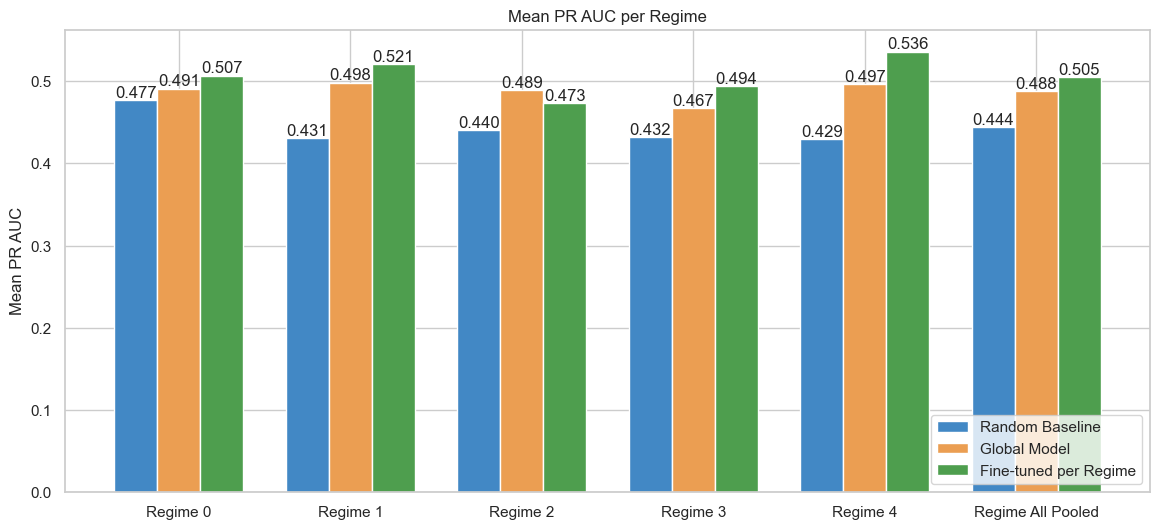

In [28]:
regimes = prev_regime_values.copy()

means_random = []
means_finetune = []
means_global = []

for regime_value in prev_regime_values:
    means_random.append(np.mean(regimes_y_val_total[regime_value]))  # Random baseline
    means_finetune.append(average_precision_score(regimes_y_val_total[regime_value],
                                                  regimes_y_val_total_pred_proba[regime_value]))
    means_global.append(average_precision_score(regimes_y_val_total[regime_value],
                                                 global_regimes_y_val_total_pred_proba[regime_value]))
    
# --- Pooled regime ---
y_true_all = np.concatenate([regimes_y_val_total[r] for r in regimes])
y_pred_finetune_all = np.concatenate([regimes_y_val_total_pred_proba[r] for r in regimes])
y_pred_global_all = np.concatenate([global_regimes_y_val_total_pred_proba[r] for r in regimes])

# Pooled metrics
auc_f_all = average_precision_score(y_true_all, y_pred_finetune_all)
auc_g_all = average_precision_score(y_true_all, y_pred_global_all)
frac_pos_all = np.mean(y_true_all)

# Append pooled values to lists
means_random.append(frac_pos_all)
means_global.append(auc_g_all)
means_finetune.append(auc_f_all)
regimes.append("All Pooled")  # Add a label for the pooled regime

# Bar positions
spacing = 1.2   
x = np.arange(len(regimes)) * spacing
width = 0.3

# Plot
plt.figure(figsize=(14, 6))
bars1 = plt.bar(x - width, means_random, width, label="Random Baseline", color="#4288c5")
bars2 = plt.bar(x, means_global, width, label="Global Model", color="#eb9e52")
bars3 = plt.bar(x + width, means_finetune, width, label="Fine-tuned per Regime", color="#4e9e4e")

plt.ylabel("Mean PR AUC")
plt.title("Mean PR AUC per Regime")
plt.xticks(x, [f"Regime {r}" for r in regimes])
plt.legend(loc='lower right')

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2,
                 bar.get_height(),
                 f"{bar.get_height():.3f}",
                 ha='center', va='bottom')

plt.show()

regimes.remove("All Pooled")

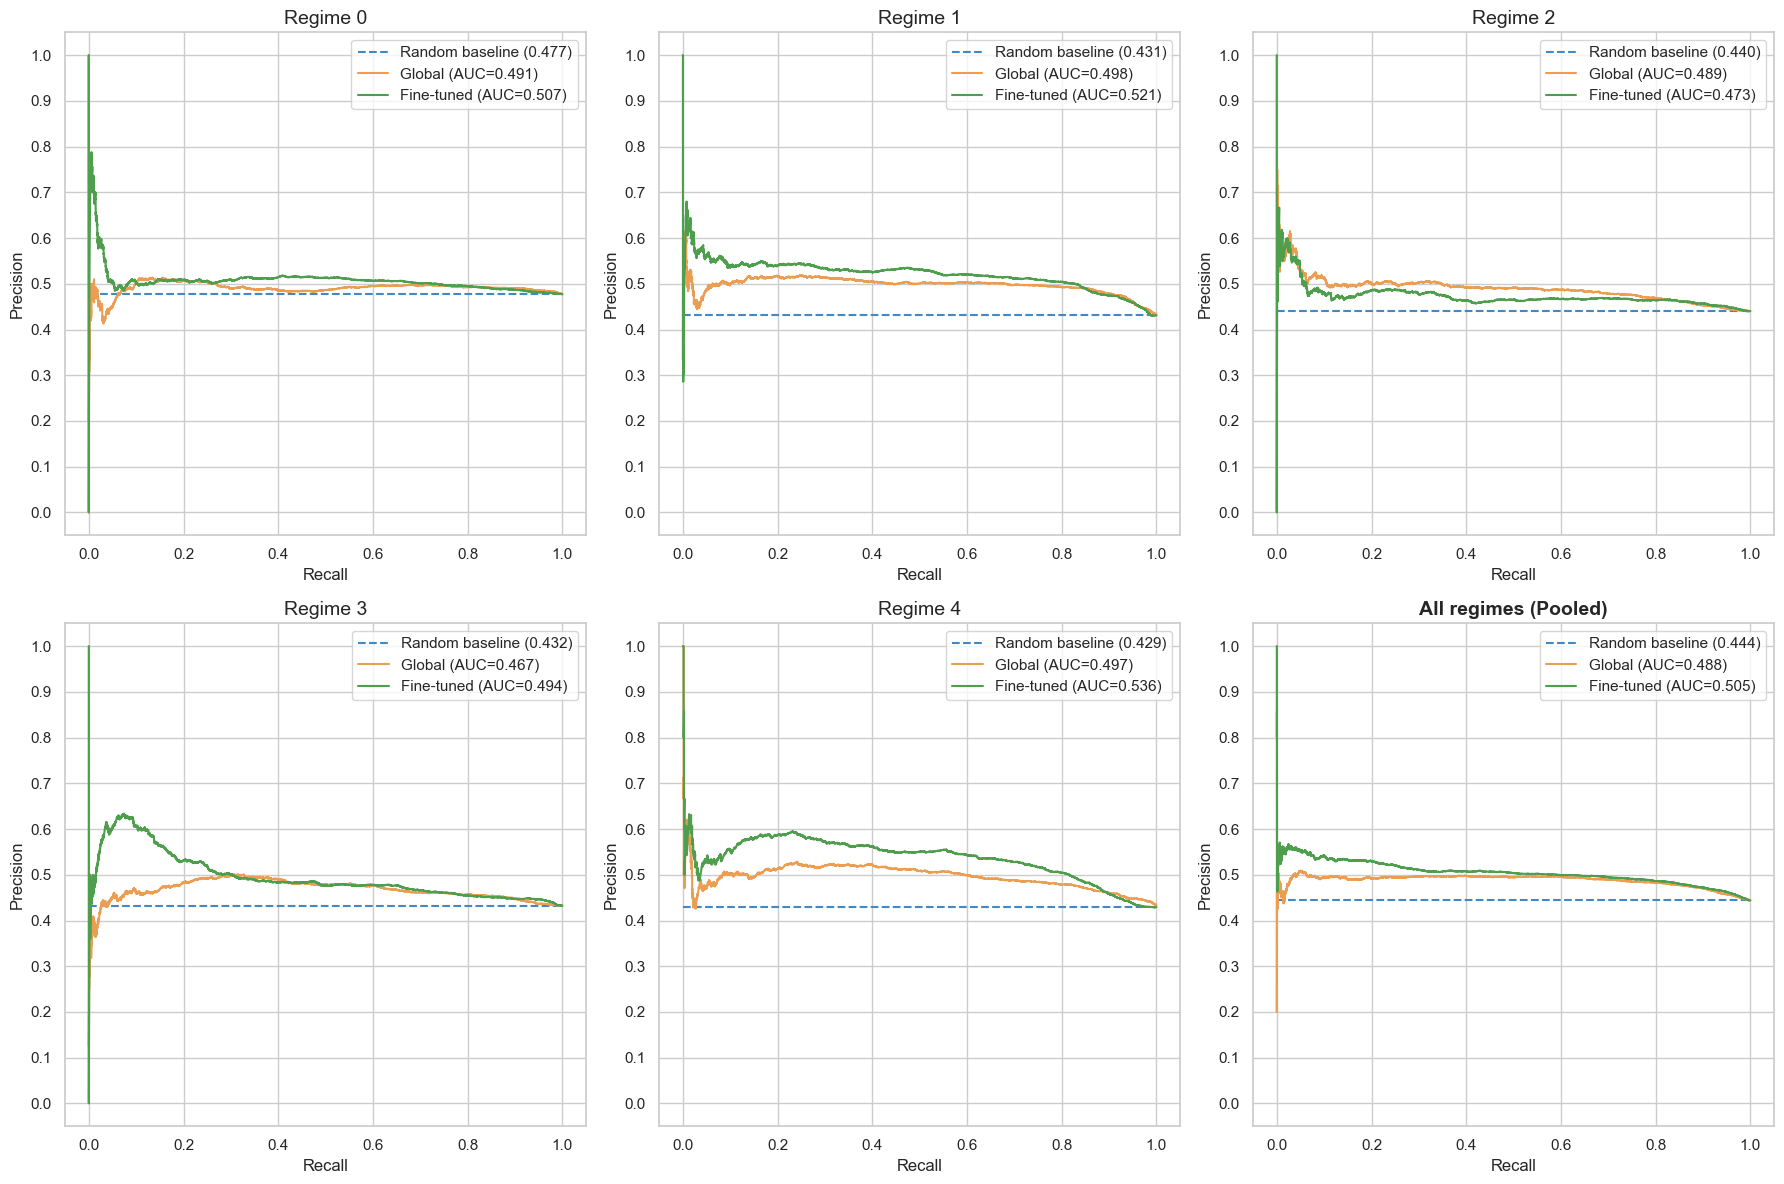

In [29]:
# Create subplots (2x3 grid)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# ---- Plot each regime in its own subplot ----
for idx, regime_value in enumerate(regimes):
    ax = axes[idx]

    # Random baseline (fraction of positives)
    frac_pos = np.mean(regimes_y_val_total[regime_value])
    ax.hlines(frac_pos, 0, 1, linestyles="dashed", colors="#4288c5",
              label=f"Random baseline ({frac_pos:.3f})")

    # Global
    precision_g, recall_g, _ = precision_recall_curve(
        regimes_y_val_total[regime_value],
        global_regimes_y_val_total_pred_proba[regime_value]
    )
    auc_g = average_precision_score(
        regimes_y_val_total[regime_value],
        global_regimes_y_val_total_pred_proba[regime_value]
    )
    ax.plot(recall_g, precision_g, color="#eb9e52",
            label=f"Global (AUC={auc_g:.3f})")
    
    # Fine-tuned
    precision_f, recall_f, _ = precision_recall_curve(
        regimes_y_val_total[regime_value],
        regimes_y_val_total_pred_proba[regime_value]
    )
    auc_f = average_precision_score(
        regimes_y_val_total[regime_value],
        regimes_y_val_total_pred_proba[regime_value]
    )
    ax.plot(recall_f, precision_f,  color="#4e9e4e", 
            label=f"Fine-tuned (AUC={auc_f:.3f})")

    # Formatting
    ax.set_title(f"Regime {regime_value}", fontsize=14)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks(np.arange(0.0, 1.01, 0.1))
    ax.grid(True)
    ax.legend()

# ---- Global + Fine-tuned pooled PR curves in last subplot ----
ax_global = axes[-1]

# Concatenate all regimes
y_true_all = np.concatenate([regimes_y_val_total[r] for r in regimes])

# Pooled fine-tuned
y_pred_finetune_all = np.concatenate([regimes_y_val_total_pred_proba[r] for r in regimes])
precision_f_all, recall_f_all, _ = precision_recall_curve(y_true_all, y_pred_finetune_all)
auc_f_all = average_precision_score(y_true_all, y_pred_finetune_all)

# Pooled global
y_pred_global_all = np.concatenate([global_regimes_y_val_total_pred_proba[r] for r in regimes])
precision_g_all, recall_g_all, _ = precision_recall_curve(y_true_all, y_pred_global_all)
auc_g_all = average_precision_score(y_true_all, y_pred_global_all)

# Random baseline (pooled positive fraction)
frac_pos_all = np.mean(y_true_all)
ax_global.hlines(frac_pos_all, 0, 1, linestyles="dashed", colors="#4288c5",
                 label=f"Random baseline ({frac_pos_all:.3f})")

# Curves with pastel colors
ax_global.plot(recall_g_all, precision_g_all, color="#eb9e52",
               label=f"Global (AUC={auc_g_all:.3f})")
ax_global.plot(recall_f_all, precision_f_all, color="#4e9e4e",
               label=f"Fine-tuned (AUC={auc_f_all:.3f})")

# Formatting
ax_global.set_title("All regimes (Pooled)", fontsize=14, fontweight='bold')
ax_global.set_xlabel("Recall")
ax_global.set_ylabel("Precision")
ax_global.set_xlim(-0.05, 1.05)
ax_global.set_ylim(-0.05, 1.05)
ax_global.set_yticks(np.arange(0.0, 1.01, 0.1))
ax_global.grid(True)
ax_global.legend()

plt.tight_layout()
plt.show()

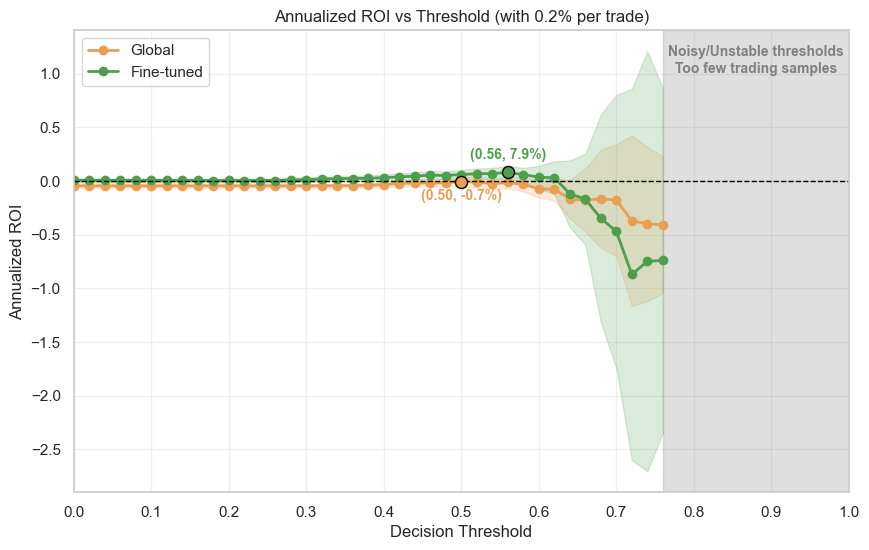

In [30]:
roi_df = pd.DataFrame(roi_results)

palette = {'Global': "#eb9e52", 'Fine-tuned': "#4e9e4e"}

plt.figure(figsize=(10,6))

# Average ROI across folds (mean + std shading)
# grouped by threshold × model, For each group, we have multiple values (because we collected ROI per fold)
# The line plotted is simply the mean of roi_annualized across folds for that group
for model, color in palette.items():
    subset = roi_df[roi_df['model'] == model]
    grouped = subset.groupby("threshold")['roi_annualized']
    
    mean_roi = grouped.mean()
    # sem is standard error of the mean (SEM), quantifies the uncertainty of the estimated mean ROI
    sem = grouped.std() / (grouped.count()**0.5)
    ci = sem * 1.645   # 90% CI
    
    # Line + datapoints
    plt.plot(mean_roi.index, mean_roi.values, 'o-', color=color, label=model, linewidth=2, markersize=6)
    
    # Shaded CI band
    plt.fill_between(
        mean_roi.index,
        mean_roi - ci,
        mean_roi + ci,
        color=color,
        alpha=0.2
    )

    # === Annotate max point ===
    max_idx = mean_roi.idxmax()
    max_val = mean_roi.loc[max_idx]
    plt.scatter(max_idx, max_val, color=color, s=75, edgecolor='black', zorder=5)
    
    if model == "Global":
        offset = -0.2
    else:
        offset = 0.1
    
    plt.text(
        max_idx, max_val + offset,
        f"({max_idx:.2f}, {max_val:.1%})",
        fontsize=10, ha='center', va='bottom', color=color, weight='bold'
    )

# === Grey shaded area beyond last threshold ===
last_threshold = roi_df['threshold'].max()
plt.axvspan(last_threshold, 1.0, color='grey', alpha=0.25)

# Add annotation inside grey area
plt.text(
    (last_threshold + 1.0)/2, plt.ylim()[1]*0.9,
    "Noisy/Unstable thresholds\nToo few trading samples",
    ha='center', va='top', fontsize=10, color='grey', weight='bold'
)

# Final formatting
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title(f"Annualized ROI vs Threshold (with {COMMISSION*100}% per trade)")
plt.xlabel("Decision Threshold")
plt.ylabel("Annualized ROI")
plt.xticks(np.arange(0.0, 1.01, 0.1))
plt.xlim(0.0, 1.0)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


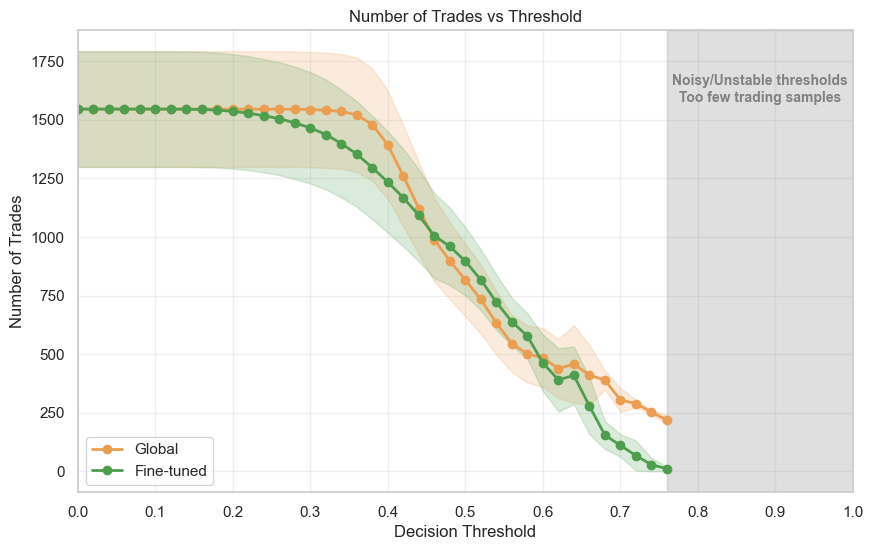

In [31]:
plt.figure(figsize=(10,6))

for model, color in palette.items():
    subset = roi_df[roi_df['model'] == model]
    grouped = subset.groupby("threshold")['n_trades']
    
    mean_trades = grouped.mean()
    sem = grouped.std() / (grouped.count()**0.5)
    ci = sem * 1.645  # 90% CI
    
    # Line + CI shading
    plt.plot(mean_trades.index, mean_trades.values, 'o-', color=color, label=model, linewidth=2, markersize=6)
    plt.fill_between(
        mean_trades.index,
        mean_trades - ci,
        mean_trades + ci,
        color=color,
        alpha=0.2
    )

# Grey rectangle beyond last threshold
last_threshold = roi_df['threshold'].max()
plt.axvspan(last_threshold, 1.0, color='grey', alpha=0.25)

# Annotation inside grey area
plt.text(
    (last_threshold + 1.0)/2, plt.ylim()[1]*0.9,
    "Noisy/Unstable thresholds\nToo few trading samples",
    ha='center', va='top', fontsize=10, color='grey', weight='bold'
)

# Formatting
plt.title("Number of Trades vs Threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Number of Trades")
plt.xticks(np.arange(0.0, 1.01, 0.1))
plt.xlim(0.0, 1.0)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()